In [10]:
import datetime
import matplotlib.pyplot as plt
import math
import numpy as np
import os

In [ ]:
import torch
from torchvision import datasets

# Get MNIST data

In [3]:
def generate_pair_sets():
    data_dir = os.environ.get('PYTORCH_DATA_DIR')
    if data_dir is None:
        data_dir = './data'

    train_set = datasets.MNIST(data_dir + '/mnist/', train = True, download = True)
    train_features = train_set.train_data.view(-1, 1, 28, 28).float()
    train_target = train_set.train_labels
    train_features = torch.functional.F.avg_pool2d(train_features, kernel_size = 2)

    test_set = datasets.MNIST(data_dir + '/mnist/', train = False, download = True)
    test_features = test_set.test_data.view(-1, 1, 28, 28).float()
    test_target = test_set.test_labels
    test_features = torch.functional.F.avg_pool2d(test_features, kernel_size = 2)

    return train_features, train_target, test_features, test_target

In [4]:
import warnings
warnings.filterwarnings('ignore')
train_features, train_target, test_features, test_target = generate_pair_sets()

In [5]:
print(train_features.shape, train_target.shape)
print(test_features.shape, test_target.shape)

torch.Size([60000, 1, 14, 14]) torch.Size([60000])
torch.Size([10000, 1, 14, 14]) torch.Size([10000])


In [6]:
data_size = 1000
train_perm = torch.randperm(train_features.size(0))
idx = train_perm[:data_size]
train_features = train_features[idx].reshape([data_size, train_features.size(2)**2])
train_target = train_target[idx]

test_perm = torch.randperm(test_features.size(0))
idx = test_perm[:data_size]
test_features = test_features[idx].reshape([data_size, test_features.size(2)**2])
test_target = test_target[idx]

In [7]:
def normalize(tensor):
    mean, std = tensor.mean(), tensor.std()
    return tensor.sub_(mean).div_(std)

normalize(train_features)
normalize(test_features)
print(train_features.shape, train_target.shape)
print(test_features.shape, test_target.shape)

torch.Size([1000, 196]) torch.Size([1000])
torch.Size([1000, 196]) torch.Size([1000])


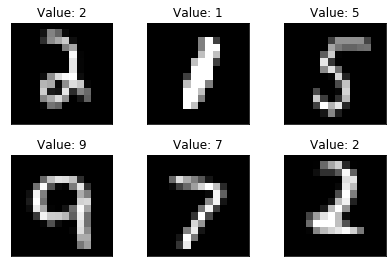

In [8]:
# displaying samples of data
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(test_features[i].reshape([14, 14]), cmap='gray', interpolation='none')
    plt.title("Value: {}".format(test_target[i]))  
    plt.tight_layout()
    plt.xticks([])
    plt.yticks([])

# Pytorch model

In [9]:
# device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Fully connected neural network
class NeuralNet(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_class, dropout_p):
        super(NeuralNet, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size) 
        self.ReLU = torch.nn.ReLU() 
        self.softmax = torch.nn.Softmax(dim=1)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)  
        self.fc3 = torch.nn.Linear(hidden_size, num_class) 
        self.dropout = torch.nn.Dropout(dropout_p) 
    
    def forward(self, x):
        x = self.ReLU(self.fc1(x))
        x = self.ReLU(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

In [10]:
# function to train each model
def train_model(model_, train_features_, train_target_, criterion_, optimizer_, num_epochs_, batch_size_, learning_rate_decay):
    # getting start time of train to get the train time at the end thanks to "end_time"
    start_time = datetime.datetime.now()
    # list to get train and test errors at each epoch
    train_error = []
    test_error = []
    # train function
    # Learning rate decay can be enabled or disabled than to an input in the function's parameters
    if learning_rate_decay:
        lambda_ = lambda epoch: 0.8 ** epoch
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer_, lr_lambda=lambda_)
    for epoch in range(1, num_epochs_+1):
        # using technique of mini batch (size of the batch in the function's parameters)
        for i in range(int(len(train_features_)/batch_size_)):  
            # getting images and labels in right format
            images = train_features_.narrow(0,i*batch_size_,batch_size_)
            labels = train_target_.narrow(0,i*batch_size_,batch_size_)

            # Forward pass
            outputs = model_(images)
            loss = criterion_(outputs, labels)

            # Backward and optimize
            optimizer_.zero_grad()
            loss.backward()
            optimizer_.step()

        if learning_rate_decay:
            scheduler.step()
        # getting train error at each epoch
        train_error.append(test_accuracy(model_, train_features_, train_target_))
        test_error.append(test_accuracy(model_, test_features, test_target))
    # getting end time and training time
    training_time = datetime.datetime.now() - start_time
    print('Training time: {}'.format(training_time))
    print('Loss: {:.4f} on final epoch: {}. Train error: {:.5f}%, Test error: {:.5f}%'.format(loss.item(),epoch,train_error[-1],test_error[-1]))
    return train_error, test_error, training_time

In [11]:
def test_accuracy(model_, my_test_features_, my_test_target_):
    outputs = model_(my_test_features_)
    _, predictions = torch.max(outputs.data, 1)
    count_errors = (predictions.long() != my_test_target_.long()).sum().item()
    return count_errors / my_test_features_.size(0) * 100

# Homemade framework

In [12]:
%load_ext autoreload
%autoreload 2
from homemade_framework import framework as NN

# Models parameters

In [13]:
# number of epoch
num_epochs = 200
# batch size to compute mini-batch
batch_size = 10
# number of pixels in the image 
input_size = 196
# number of possible digit: 0 to 9 
num_class = 10
# small step to find a minima
learning_rate = 0.01
# hidden size
hidden_size = 128
# p dropout
p_dropout = 0
# learning rate decay
LRD = False

# Train pytorch model

model = NeuralNet(input_size, hidden_size, num_class, p_dropout)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  
train_error, test_error, train_time = train_model(model, train_features, train_target, criterion, optimizer, num_epochs, batch_size, LRD)

# Train homemade model

In [14]:
# convert data to numpy array
train_features_np, train_target_np = train_features.numpy(), train_target.numpy()
test_features_np, test_target_np = test_features.numpy(), test_target.numpy()

# Build the model
Model = NN.Sequential([NN.Linear(input_size, hidden_size), NN.LeakyReLU(),
                       NN.Linear(hidden_size, hidden_size), NN.LeakyReLU(),
                       NN.Linear(hidden_size, num_class), NN.Softmax()], NN.LossMSE())
# Set the learning rate
Model.set_Lr(learning_rate)
# Print model's parameters
Model.print(print_color=False)

NN.train_homemade_model(Model, num_epochs, train_features_np, train_target_np, test_features_np, test_target_np, batch_size)

Model description: 
	Linear layer shape: [196, 128]
	LeakyReLU activation
	Linear layer shape: [128, 128]
	LeakyReLU activation
	Linear layer shape: [128, 10]
	Softmax function
	MSE
Before training: Epoch: 0, Train Error: 92.2000%,        Test Error: 91.3000%, Loss  0.0000
Epoch: 1, Train Error: 59.5000%,        Test Error: 61.6000%, Loss  87.5858
Epoch: 31, Train Error: 5.7000%,        Test Error: 14.0000%, Loss  10.2146
Epoch: 61, Train Error: 3.4000%,        Test Error: 13.3000%, Loss  4.6154
Epoch: 91, Train Error: 2.5000%,        Test Error: 13.1000%, Loss  2.7314
Epoch: 121, Train Error: 1.9000%,        Test Error: 13.5000%, Loss  2.3909
Epoch: 151, Train Error: 1.2000%,        Test Error: 13.1000%, Loss  1.3412
Epoch: 181, Train Error: 1.0000%,        Test Error: 13.1000%, Loss  1.1897

Training time: 0:00:24.131070
After training: Epoch: 199, Train Error: 0.9000%,        Test Error: 13.8000%, Loss  0.9333


In [15]:
nb = 2
train_features_tmp, train_target_tmp = train_features_np.reshape([1000,14,14])[0:nb], train_target_np[0:nb]
test_features_tmp, test_target_tmp = test_features_np.reshape([1000,14,14])[0:nb], test_target_np[0:nb]

In [16]:
print("train features shape: {} \ntrain target shape: {},\
      \ntest features shape: {},\ntest target shape: {}".format(train_features_tmp.shape, train_target_tmp.shape,
                                                             test_features_tmp.shape, test_target_tmp.shape))

train features shape: (2, 14, 14) 
train target shape: (2,),      
test features shape: (2, 14, 14),
test target shape: (2,)


In [18]:
# Build the model
Model = NN.Sequential([NN.Convolution(), NN.LeakyReLU(),
                       NN.Convolution(), NN.LeakyReLU(),
                       NN.Flatten(),
                       NN.Linear(100, num_class), NN.Softmax()], NN.LossMSE())
# Set the learning rate
Model.set_Lr(learning_rate)
# Print model's parameters
Model.print(print_color=True)

Model description: Linear in green, Activation in blue, Loss in magenta, Softmax in red, Flatten in Gray, Convolution in Cyan
	Convolution feature maps: 16, kernel size: (16, 3, 3)
	LeakyReLU activation
	Convolution feature maps: 16, kernel size: (16, 3, 3)
	LeakyReLU activation
	Flatten function
	Linear layer shape: [100, 10]
	Softmax function
	MSE


# Forward pass: 1 channel data, 1 feature map

In [69]:
x = np.array([[1,2,3,4], [5,6,7,8], [9,10,11,12], [13,14,15,16], [13,14,15,16], [1,2,3,4]])
x

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12],
       [13, 14, 15, 16],
       [13, 14, 15, 16],
       [ 1,  2,  3,  4]])

In [70]:
kernel = np.array([[1,2,3], [4,5,6], [7,8,9]])
kernel

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [71]:
np.matmul(kernel.reshape([np.prod(kernel.shape)]), kernel.reshape([np.prod(kernel.shape)]))

285

In [72]:
math.ceil(x.shape[0]/2)

3

In [73]:
kernel_size = 3
stride = 1

patches = np.asarray([x[stride*j:stride*j+kernel.shape[0], stride*k:stride*k+kernel.shape[1]] 
                      for j in range(x.shape[0]-kernel.shape[0]+1)
                      for k in range(x.shape[1]-kernel.shape[1]+1)])
patches

array([[[ 1,  2,  3],
        [ 5,  6,  7],
        [ 9, 10, 11]],

       [[ 2,  3,  4],
        [ 6,  7,  8],
        [10, 11, 12]],

       [[ 5,  6,  7],
        [ 9, 10, 11],
        [13, 14, 15]],

       [[ 6,  7,  8],
        [10, 11, 12],
        [14, 15, 16]],

       [[ 9, 10, 11],
        [13, 14, 15],
        [13, 14, 15]],

       [[10, 11, 12],
        [14, 15, 16],
        [14, 15, 16]],

       [[13, 14, 15],
        [13, 14, 15],
        [ 1,  2,  3]],

       [[14, 15, 16],
        [14, 15, 16],
        [ 2,  3,  4]]])

In [74]:
patches = patches.reshape([patches.shape[0], kernel.shape[0]*kernel.shape[1]])
patches

array([[ 1,  2,  3,  5,  6,  7,  9, 10, 11],
       [ 2,  3,  4,  6,  7,  8, 10, 11, 12],
       [ 5,  6,  7,  9, 10, 11, 13, 14, 15],
       [ 6,  7,  8, 10, 11, 12, 14, 15, 16],
       [ 9, 10, 11, 13, 14, 15, 13, 14, 15],
       [10, 11, 12, 14, 15, 16, 14, 15, 16],
       [13, 14, 15, 13, 14, 15,  1,  2,  3],
       [14, 15, 16, 14, 15, 16,  2,  3,  4]])

In [75]:
kernel_repeat = np.repeat(kernel.reshape([1, np.prod(kernel.shape)]), patches.shape[0], axis=0)
kernel_repeat

array([[1, 2, 3, 4, 5, 6, 7, 8, 9],
       [1, 2, 3, 4, 5, 6, 7, 8, 9],
       [1, 2, 3, 4, 5, 6, 7, 8, 9],
       [1, 2, 3, 4, 5, 6, 7, 8, 9],
       [1, 2, 3, 4, 5, 6, 7, 8, 9],
       [1, 2, 3, 4, 5, 6, 7, 8, 9],
       [1, 2, 3, 4, 5, 6, 7, 8, 9],
       [1, 2, 3, 4, 5, 6, 7, 8, 9]])

In [76]:
result = np.asarray([np.matmul(kernel_repeat[i,:], patches[i,:]) for i in range(kernel_repeat.shape[0])])
result

array([348, 393, 528, 573, 612, 657, 348, 393])

In [77]:
result = result.reshape([x.shape[0]-kernel.shape[0]+1, x.shape[1]-kernel.shape[1]+1])
result

array([[348, 393],
       [528, 573],
       [612, 657],
       [348, 393]])

In [107]:
x = np.array([[1,2,3,4], [5,6,7,8], [9,10,11,12], [13,14,15,16], [13,14,15,16], [1,2,3,4], [1,2,3,4], [1,2,3,4]])
kernel = np.array([[1,2,3], [4,5,6], [7,8,9]])
patches = np.asarray([x[stride*j:stride*j+kernel.shape[0], stride*k:stride*k+kernel.shape[1]] 
                      for j in range(x.shape[0]-kernel.shape[0]+1)
                      for k in range(x.shape[1]-kernel.shape[1]+1)])
patches = patches.reshape([patches.shape[0], kernel.shape[0]*kernel.shape[1]])
kernel_repeat = np.repeat(kernel.reshape([1, np.prod(kernel.shape)]), patches.shape[0], axis=0)
result = np.asarray([np.matmul(kernel_repeat[i,:], patches[i,:]) for i in range(kernel_repeat.shape[0])])
result = result.reshape([x.shape[0]-kernel.shape[0]+1, x.shape[1]-kernel.shape[1]+1])
result

array([[348, 393],
       [528, 573],
       [612, 657],
       [348, 393],
       [168, 213],
       [ 96, 141]])

# Forward pass: 1 channel data, several feature maps

In [108]:
kernel = np.array([[[1,2,3], [4,5,6], [7,8,9]], [[10,20,30], [40,50,60], [70,80,90]]])
kernel.shape

(2, 3, 3)

In [109]:
depth = kernel.shape[0]
k_height = kernel.shape[1]
k_width = kernel.shape[2]

patches = np.asarray([x[stride*j:stride*j+k_height, stride*k:stride*k+k_width] 
                      for j in range(x.shape[0]-k_height+1)
                      for k in range(x.shape[1]-k_width+1)])
patches

array([[[ 1,  2,  3],
        [ 5,  6,  7],
        [ 9, 10, 11]],

       [[ 2,  3,  4],
        [ 6,  7,  8],
        [10, 11, 12]],

       [[ 5,  6,  7],
        [ 9, 10, 11],
        [13, 14, 15]],

       [[ 6,  7,  8],
        [10, 11, 12],
        [14, 15, 16]],

       [[ 9, 10, 11],
        [13, 14, 15],
        [13, 14, 15]],

       [[10, 11, 12],
        [14, 15, 16],
        [14, 15, 16]],

       [[13, 14, 15],
        [13, 14, 15],
        [ 1,  2,  3]],

       [[14, 15, 16],
        [14, 15, 16],
        [ 2,  3,  4]],

       [[13, 14, 15],
        [ 1,  2,  3],
        [ 1,  2,  3]],

       [[14, 15, 16],
        [ 2,  3,  4],
        [ 2,  3,  4]],

       [[ 1,  2,  3],
        [ 1,  2,  3],
        [ 1,  2,  3]],

       [[ 2,  3,  4],
        [ 2,  3,  4],
        [ 2,  3,  4]]])

In [110]:
patches = patches.reshape([patches.shape[0], k_height*k_width])
patches

array([[ 1,  2,  3,  5,  6,  7,  9, 10, 11],
       [ 2,  3,  4,  6,  7,  8, 10, 11, 12],
       [ 5,  6,  7,  9, 10, 11, 13, 14, 15],
       [ 6,  7,  8, 10, 11, 12, 14, 15, 16],
       [ 9, 10, 11, 13, 14, 15, 13, 14, 15],
       [10, 11, 12, 14, 15, 16, 14, 15, 16],
       [13, 14, 15, 13, 14, 15,  1,  2,  3],
       [14, 15, 16, 14, 15, 16,  2,  3,  4],
       [13, 14, 15,  1,  2,  3,  1,  2,  3],
       [14, 15, 16,  2,  3,  4,  2,  3,  4],
       [ 1,  2,  3,  1,  2,  3,  1,  2,  3],
       [ 2,  3,  4,  2,  3,  4,  2,  3,  4]])

In [111]:
kernel_repeat = np.repeat(kernel.reshape([depth, 1, k_height*k_width]), patches.shape[0], axis=1)
kernel_repeat.shape

(2, 12, 9)

In [112]:
kernel_repeat

array([[[ 1,  2,  3,  4,  5,  6,  7,  8,  9],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9]],

       [[10, 20, 30, 40, 50, 60, 70, 80, 90],
        [10, 20, 30, 40, 50, 60, 70, 80, 90],
        [10, 20, 30, 40, 50, 60, 70, 80, 90],
        [10, 20, 30, 40, 50, 60, 70, 80, 90],
        [10, 20, 30, 40, 50, 60, 70, 80, 90],
        [10, 20, 30, 40, 50, 60, 70, 80, 90],
        [10, 20, 30, 40, 50, 60, 70, 80, 90],
        [10, 20, 30, 40, 50, 60, 70, 80, 90],
        [10, 20, 30, 40, 50, 60, 70, 80, 90],
        [10, 20, 30, 40, 50, 60,

In [113]:
result = np.asarray([np.matmul(kernel_repeat[i, j,:], patches[j,:]) for i in range(kernel_repeat.shape[0]) for j in range(kernel_repeat.shape[1])])
result

array([ 348,  393,  528,  573,  612,  657,  348,  393,  168,  213,   96,
        141, 3480, 3930, 5280, 5730, 6120, 6570, 3480, 3930, 1680, 2130,
        960, 1410])

In [114]:
result = result.reshape([kernel_repeat.shape[0], x.shape[0]-k_height+1, x.shape[1]-k_width+1])
result

array([[[ 348,  393],
        [ 528,  573],
        [ 612,  657],
        [ 348,  393],
        [ 168,  213],
        [  96,  141]],

       [[3480, 3930],
        [5280, 5730],
        [6120, 6570],
        [3480, 3930],
        [1680, 2130],
        [ 960, 1410]]])

In [115]:
result.shape

(2, 6, 2)

# Forward pass: several channels input, several feature maps

In [141]:
x = np.array([[[1,2,3,4], [5,6,7,8], [9,10,11,12], [13,14,15,16], [13,14,15,16], [1,2,3,4]],
              [[10,20,30,40], [50,60,70,80], [90,100,110,120], [130,140,150,160], [130,140,150,160], [10,20,30,40]],
              [[100,200,300,400], [500,600,700,800], [900,1000,1100,1200], [1300,1400,1500,1600], [1300,1400,1500,1600], [100,200,300,400]],
             [[1,2,3,4], [5,6,7,8], [9,10,11,12], [13,14,15,16], [13,14,15,16], [1,2,3,4]],
              ])
x.shape

(4, 6, 4)

In [163]:
kernel = np.array([[[[1,2,3], [4,5,6], [7,8,9]],
                   [[10,20,30], [40,50,60], [70,80,90]],
                   [[10,20,30], [40,50,60], [70,80,90]],
                   [[10,20,30], [40,50,60], [70,80,90]]],
                   [[[1,2,3], [4,5,6], [7,8,9]],
                   [[10,20,30], [40,50,60], [70,80,90]],
                   [[10,20,30], [40,50,60], [70,80,90]],
                   [[10,20,30], [40,50,60], [70,80,90]]]])
kernel.shape

(2, 4, 3, 3)

In [176]:
x_depth = x.shape[0]
x_height = x.shape[1]
x_width = x.shape[2]

k_output = kernel.shape[0]
k_depth = kernel.shape[1]
k_height = kernel.shape[2]
k_width = kernel.shape[3]

In [177]:
patches = np.asarray([x[c, stride*j:stride*j+k_height, stride*k:stride*k+k_width] 
                      for c in range(x_depth)
                      for j in range(x_height-k_height+1)
                      for k in range(x_width-k_width+1)])
patches.shape

(32, 3, 3)

In [178]:
patches.shape

(32, 3, 3)

In [179]:
patches = patches.reshape([x_depth, patches.shape[0]//x_depth, k_height*k_width])
patches

array([[[   1,    2,    3,    5,    6,    7,    9,   10,   11],
        [   2,    3,    4,    6,    7,    8,   10,   11,   12],
        [   5,    6,    7,    9,   10,   11,   13,   14,   15],
        [   6,    7,    8,   10,   11,   12,   14,   15,   16],
        [   9,   10,   11,   13,   14,   15,   13,   14,   15],
        [  10,   11,   12,   14,   15,   16,   14,   15,   16],
        [  13,   14,   15,   13,   14,   15,    1,    2,    3],
        [  14,   15,   16,   14,   15,   16,    2,    3,    4]],

       [[  10,   20,   30,   50,   60,   70,   90,  100,  110],
        [  20,   30,   40,   60,   70,   80,  100,  110,  120],
        [  50,   60,   70,   90,  100,  110,  130,  140,  150],
        [  60,   70,   80,  100,  110,  120,  140,  150,  160],
        [  90,  100,  110,  130,  140,  150,  130,  140,  150],
        [ 100,  110,  120,  140,  150,  160,  140,  150,  160],
        [ 130,  140,  150,  130,  140,  150,   10,   20,   30],
        [ 140,  150,  160,  140,  150,

In [180]:
patches.shape

(4, 8, 9)

In [182]:
kernel_repeat = np.repeat(kernel.reshape([k_channel, k_depth, 1, k_height*k_width]), patches.shape[1], axis=2)
kernel_repeat.shape

(2, 4, 8, 9)

In [187]:
result = np.asarray([np.matmul(kernel_repeat[o, i, j,:], patches[c,j,:])
                     for o in range(k_output)
                     for c in range(patches.shape[0])
                     for i in range(kernel_repeat.shape[0])
                     for j in range(kernel_repeat.shape[1])])
result

array([   348,    393,    528,    573,   3480,   3930,   5280,   5730,
         3480,   3930,   5280,   5730,  34800,  39300,  52800,  57300,
        34800,  39300,  52800,  57300, 348000, 393000, 528000, 573000,
          348,    393,    528,    573,   3480,   3930,   5280,   5730,
          348,    393,    528,    573,   3480,   3930,   5280,   5730,
         3480,   3930,   5280,   5730,  34800,  39300,  52800,  57300,
        34800,  39300,  52800,  57300, 348000, 393000, 528000, 573000,
          348,    393,    528,    573,   3480,   3930,   5280,   5730])

In [188]:
result.shape

(64,)

In [192]:
result = result.reshape([kernel_repeat.shape[0], kernel_repeat.shape[1], x_height-k_height+1, x_width-k_width+1])
result

array([[[[   348,    393],
         [   528,    573],
         [  3480,   3930],
         [  5280,   5730]],

        [[  3480,   3930],
         [  5280,   5730],
         [ 34800,  39300],
         [ 52800,  57300]],

        [[ 34800,  39300],
         [ 52800,  57300],
         [348000, 393000],
         [528000, 573000]],

        [[   348,    393],
         [   528,    573],
         [  3480,   3930],
         [  5280,   5730]]],


       [[[   348,    393],
         [   528,    573],
         [  3480,   3930],
         [  5280,   5730]],

        [[  3480,   3930],
         [  5280,   5730],
         [ 34800,  39300],
         [ 52800,  57300]],

        [[ 34800,  39300],
         [ 52800,  57300],
         [348000, 393000],
         [528000, 573000]],

        [[   348,    393],
         [   528,    573],
         [  3480,   3930],
         [  5280,   5730]]]])

In [193]:
result.shape

(2, 4, 4, 2)

In [197]:
output = np.sum(result, axis=1)

In [198]:
output.shape

(2, 4, 2)